In [1]:
# imports 
import pandas as pd
import ipywidgets as widgets


# databases 
airports_df = pd.read_csv("../data/aeroportsANLO.csv")
routes_df = pd.read_csv("../data/routesANLO.csv")
continents_df = pd.read_csv("../data/countries.csv")

# conversion to dict continent 
continents_dict = dict(zip(continents_df['country'], continents_df['continent'])); del continents_df


In [2]:
# TODO doit etre possible plus vite 
airports_dict = dict()
for row in airports_df[['Iata','Name','Country']].iterrows():
    a = row[1][0]
    b = row[1][1]
    c = row[1][2]
    airports_dict[a] = dict(zip(['Name','Country'], [b,c]))

In [3]:
# optie 1 
r1 = routes_df[routes_df['Depart'] == 'KWE'][['Arrivee', 'Num_IATA']]
r2 = routes_df[routes_df['Arrivee'] == 'AMS'][['Depart', 'Num_IATA']]
pd.merge(r1, r2,left_on = 'Arrivee', right_on = 'Depart')

,Arrivee,Num_IATA_x,Depart,Num_IATA_y
0,CAN,AQ1028,CAN,CZ2577
1,CAN,AQ1028,CAN,CZ455
2,CAN,AQ1028,CAN,CZ307
3,CAN,AQ1028,CAN,CZ2573
4,CAN,CZ6394,CAN,CZ2577
...,...,...,...,...
121,XMN,SC8770,XMN,MF811
122,XMN,MF8438,XMN,MF811
123,XMN,GS6461,XMN,MF811
124,XMN,AQ1641,XMN,MF811


In [4]:
# optie 2
def correspondance_1airport_int(code1 : str, code2 : str):
    r1 = routes_df[routes_df['Depart'] == code1]['Arrivee'].to_list()
    r2 = routes_df[routes_df['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

print(correspondance_1airport_int('KWE', 'AMS')) # ['PVG', 'XMN', 'NKG', 'CAN', 'PEK']

['CAN', 'PVG', 'NKG', 'PEK', 'XMN']


In [5]:
graph_test_nb = {
    0: [(1, 5), (2, 1)],
    1: [(0, 5), (3, 2)],
    2: [(0, 1), (3, 1)],
    3: [(1, 4), (2, 1)]
    
}

graph_test_names = {
    'AAL': [('LPA', 5), ('DUS', 1)],
    'LPA': [('AAL', 5), ('LNZ', 2)],
    'DUS': [('AAL', 1), ('LNZ', 1)],
    'LNZ': [('LPA', 4), ('DUS', 1)],   
}

In [6]:
# creating edges 
def creation_edges(graph : dict): 
    '''
    function qui crée des edges pour le graphe 
    retour list des tuples (start, end, weight)
    '''
    edges = []

    for i in range(0,4) : 
        #print(graph_test_nb[i])
        for j in range (0, len(graph[i])):
            edges.append((i, graph[i][j][0], graph[i][j][1]))
    return edges         

e = creation_edges(graph_test_nb)


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

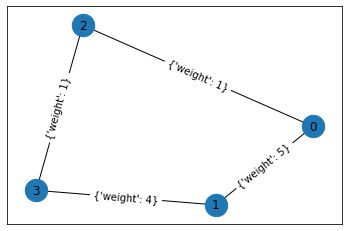

In [8]:
G = nx.Graph()

G.add_weighted_edges_from(e)
#circular_layout , spring_layout
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 500)
nx.draw_networkx_edges(G,pos, edgelist= G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos)

plt.show()

In [35]:
# input 'AAL' 'LNZ

# besoin d'une grande list qui rappel tous chiffre avec les codes des airports  
def creation_edges(listConnections, graphe, listReference, code1, code2):
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    listReference.append(code1); #  airport de depart 
    index1 = listReference.index(code1); 
    for i in listConnections :
        listReference.append(i)     
    
    listReference.append(code2); # fin list => airport de  arrivee
    index2 = listReference.index(code2)
    print(listReference)
    listEdges = []
    for i in listConnections : 
        weight = 2 # TODO doit etre remplacee par CO2
        
        indextmp = listReference.index(i)
        print(index1, indextmp, weight)
        print(indextmp, index2, weight)
        #listEdges.append((listReference[index1], i, weight))
        listEdges.append((index1, indextmp , weight))
        listEdges.append((indextmp,index2, weight))
    print(listEdges)
    graphe.add_weighted_edges_from(listEdges)
    return listReference

In [32]:
# werkt voor 'AAL' naar 'LNZ'
list1 = correspondance_1airport_int('AAL', 'LNZ')
graphe_test = nx.Graph()


creation_edges(list1, graphe_test, [], 'AAL', 'LNZ')

['AAL', 'LPA', 'DUS', 'LNZ']
0 1 2
1 3 2
0 2 2
2 3 2
[(0, 1, 2), (1, 3, 2), (0, 2, 2), (2, 3, 2)]


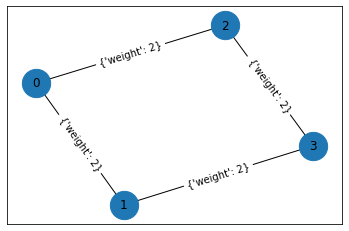

In [31]:
pos = nx.spring_layout(graphe_test)
nx.draw_networkx_nodes(graphe_test, pos, node_size = 800)
nx.draw_networkx_edges(graphe_test,pos, edgelist= graphe_test.edges(), edge_color='black')
nx.draw_networkx_labels(graphe_test, pos)
nx.draw_networkx_edge_labels(graphe_test, pos)

plt.show()

## Dijkstra algorithme try 1 
inspiration from https://pythonalgos.com/dijkstras-algorithm-in-5-steps-with-python/
number node => code_airport , 
distance => ecoprint 

In [11]:
from numpy import Inf
import heapq

In [12]:
def lazy_dijkstras(graph, root):
    n = len(graph)
    # set up "inf" distances
    dist = [Inf for _ in range(n)]
    # set up root distance
    dist[root] = 0
    # set up visited node list
    visited = [False for _ in range(n)]
    # set up priority queue
    pq = [(0, root)]
    # while there are nodes to process
    while len(pq) > 0:
        # get the root, discard current distance
        _, u = heapq.heappop(pq)
        # if the node is visited, skip
        if visited[u]:
            continue
        # set the node to visited
        visited[u] = True
        # check the distance and node and distance
        for v, l in graph[u]:
            # if the current node's distance + distance to the node we're visiting
            # is less than the distance of the node we're visiting on file
            # replace that distance and push the node we're visiting into the priority queue
            if dist[u] + l < dist[v]:
                dist[v] = dist[u] + l
                heapq.heappush(pq, (dist[v], v))
    return dist

In [13]:
#print(naive_dijkstras(graph,1))
lazy_dijkstras(graph_test_nb, 0) #[0, 5, 1, 2]

# cela veut dire que 
#    | AAL|LPA |DUS |LNZ|
# AAL  0  |  5 | 1  | 2 |
# conclusion de AAL à LNZ le plus courte chemin est 2

[0, 5, 1, 2]